# Gravitation model

Inspired by Newton's law of universal gravitation, it has been first used to predict the trading
between nations; the model is defined as:
<br>
$T_{st} = C \frac{m_s^{\alpha} n_t^{\beta}}{r_{st}^{\gamma}}$


$T_{st}$ = number of commuters from commune s to commune t
<br>
$m_s$ = population of commune s
<br>
$n_t$ = population of commune t
<br>
$r_{st}$ = distance between communes
<br>
C, $\alpha$, $\beta$, $\gamma$ = parameters to be determined to through ordinary least squares


We will use the log transformed data to fit the model using linear models:
<br>
$\log(T_{st}) = \log(C) + \alpha \log(m_s) + \beta \log(n_t) + \gamma \log(r_{st})$

We estimate the gravity model conditional on observing a positive flow as we cannot take the logarithm of 0

## Loading libraries and importing the data 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import os
from functions import *


Importing and formatting the data 

In [33]:
base_path = '/Users/leilapaolini/Documents/Data for project 2'
full_path = os.path.join(base_path, 'data_y2.npy')
data = np.load(full_path, allow_pickle=True)

print(f"Data type: {type(data)}")
print(f"Data shape: {data.shape if hasattr(data, 'shape') else 'N/A'}")

Data type: <class 'numpy.ndarray'>
Data shape: (19237044, 37)


In [34]:
df = pd.DataFrame(data, columns=['commune_1', 'commune_2', 'distance', 'year', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER',
       'GEM_FLAECH', 'EINWOHNERZ', '0-25', '25-65', '65+', 'canton_code',
       'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'BFS_NUMMER_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2',
       '25-65_2', '65+_2', 'canton_code_2', 'unemployment_2', 'gdp_2', 'flow'])

df.head()

print(df['BFS_NUMMER'].nunique())



2197


In [35]:
to_keep = ['distance', 'pop_1', 'pop_2']
drop_features = [col for col in df.columns if col not in to_keep]

X_train, y_train, X_val, y_val, X_test, y_test = build_train_test_val(df, 
                                                                      test_canton_ids=[3], 
                                                                      val_canton_ids=[], # no validation set needed
                                                                      zero_drop_ratio=1, # dropping all 0 flows
                                                                      random_state=37, 
                                                                      features=drop_features, 
                                                                      classify= False)

Splitting with canton [3] as test set:
Total flows: 251,107
Train size: 231,064 rows (92.0%)
Test size: 20,043 rows (8.0%)
Splitting with canton [] as test set:
Total flows: 231,064
Train size: 231,064 rows (100.0%)
Test size: 0 rows (0.0%)
Dropping 100% of zeros in training data


In [36]:
assert (X_train['distance'] > 0).all()
assert (X_train['pop_1'] > 0).all()
assert (X_train['pop_2'] > 0).all()

## Training and evaluation functions

In [37]:
def fit_gravity_model(X_train, y_train):
    """
        Funtion fitting the gravity model using linear regression on log-transformed data.
        X_train: DataFrame with columns ['population_s', 'population_t', 'distance', 'flow_st']
        Returns: Fitted model and parameters C, alpha, beta, gamma
    """
    # we take only the rows where flow > 0 to avoid log(0)
    # we consider that populations and distance are always > 0

    
    # apply log to each variable, X matrix contains populations and distance
    X = np.column_stack([
        np.log(X_train['pop_1']),
        np.log(X_train['pop_2']),
        np.log(X_train['distance'])
    ])
    
    # y vector contains flow
    y = np.log(y_train)
    

    # we fit using linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # we extract parameters
    C = np.exp(model.intercept_)
    alpha = model.coef_[0]
    beta = model.coef_[1]
    gamma = -model.coef_[2]  #negative sign to recover gamma
    
    print("gravity model fitted:")
    print(f"fitted parameters: C={C:.6f}, alpha={alpha:.3f}, beta={beta:.3f}, gamma={gamma:.3f}")
    
    return C, alpha, beta, gamma

In [38]:
def predict_flows(C, alpha, beta, gamma, df):
    """Predict commuter flows using fitted parameters"""
    pred = C * (df['pop_1'] ** alpha) * (df['pop_2'] ** beta) / (df['distance'] ** gamma)
    
    return pred

In [39]:
def evaluate_model(actual, predicted):
    """Evaluate and plot model performance"""
    
    # Calculate metrics
    r2 = r2_score(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = np.mean(np.abs(actual - predicted))
    correlation = np.corrcoef(actual, predicted)[0, 1]
    
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.1f} commuters")
    print(f"MAE: {mae:.1f} commuters")
    print(f"Pearson Correlation: {correlation:.3f}")
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot: predicted vs actual
    ax1.scatter(actual, predicted, alpha=0.6)
    ax1.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Commuters')
    ax1.set_ylabel('Predicted Commuters')
    ax1.set_title('Predicted vs Actual')
    ax1.grid(True, alpha=0.3)
    
    # Residual plot
    residuals = predicted - actual
    ax2.scatter(predicted, residuals, alpha=0.6)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Commuters')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'correlation': correlation}

gravity model fitted:
fitted parameters: C=29.749341, alpha=0.356, beta=0.544, gamma=0.894
R² Score: 0.165
RMSE: 111.8 commuters
MAE: 21.7 commuters
Pearson Correlation: 0.743


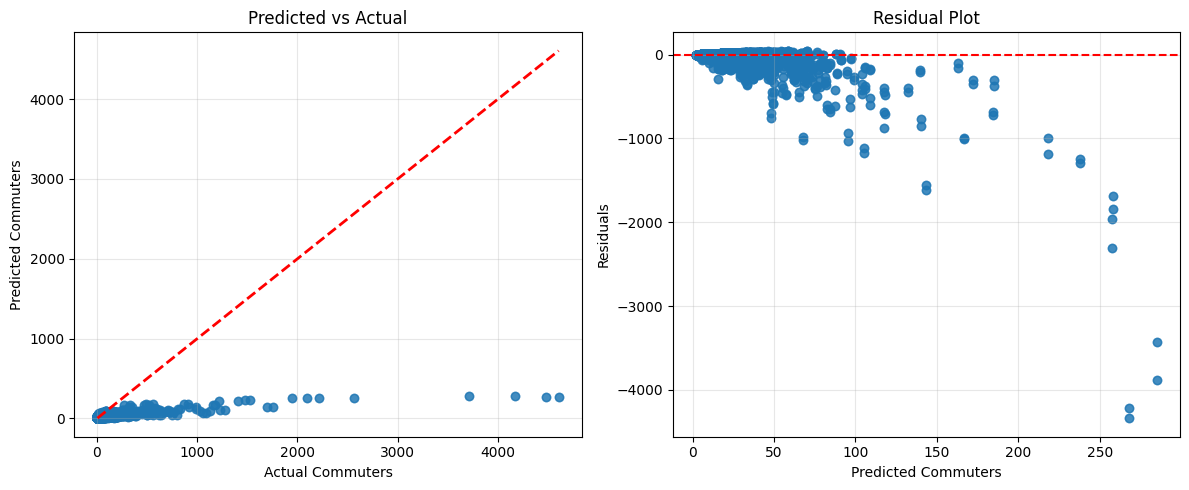

In [ ]:
C, alpha, beta, gamma = fit_gravity_model(X_train, y_train)
y_pred = predict_flows(C, alpha, beta, gamma, X_test)
metrics = evaluate_model(y_test, y_pred)
